In [3]:
from Levenshtein import distance
import numpy as np
import pandas as pd
import os
import unicodedata

In [4]:
def get_levenshtein(x,y):
    # ordering the inputs by length so that a<=b
    a=max(len(x), len(y))
    b=min(len(x), len(y))
    if a==0: # one of the input is empty
        return 1.
    if a > b+500: # if there are more than 500 more chars then return 100%
        return 1.
    # return the levenshtein distance normalized by the mean length
    mean_length = (a + b)/2.
    return 2 * distance(x,y)/mean_length

def normalize_text(x):
    return unicodedata.normalize("NFKD", x.replace(";"," "))

In [5]:
projet_loi = normalize_text("EQUILIBRE DANS LE SECTEUR AGRICOLE ET ALIMENTAIRE")

In [6]:
def lecture_amendement(folder):
    res=""
    starts=[]
    row=0
    all_amendement = []
    print("Lecture des fichiers dans {} : ".format(folder))
    for f in os.listdir(folder):
        print("{}".format(f), end=',')
        current_file= open(folder+"/"+f, encoding="iso-8859-1")
        
        for line in current_file:
            all_amendement.append(normalize_text(line.strip()))
            if line.strip()[0:len(projet_loi)] == projet_loi:
                starts.append(row-5)
            row+=1
                
        current_file.close()
    print("")
    print("")
    return starts, all_amendement


def get_amendement_nb(x):
    try:
        return x[1].replace("N° ","")
    except:
        return "0"


def get_amendement_text(x):
    start,end=0,0
    for i in range(0, len(x)):
        if x[i]==normalize_text("----------"):
            start=i+3
        if normalize_text(x[i][0:5])==normalize_text("EXPOS"):
            end=i
    candidate = x[start:end]
    res=[]
    for i in range(0, len(candidate)):
        if "Cet amendement est en cours" in candidate[i]:
            continue
        elif len(candidate[i]) < 2:
            continue
        else:
            res.append(candidate[i])
    return " ".join(res).replace("  ", " ")

def get_amendements(starts, all_amendements, version):
    amendements_nb, amendements_txt, begins, ends = [],[],[], []
    for i in range(0, len(starts)):
        if i<len(starts)-1:
            begin=starts[i]
            end=starts[i+1]
        else:
            begin=starts[-1]
            end=len(all_amendements)
        #print(begin, end)
        current_amendement = all_amendements[begin:end]
        #print(starts[i], starts[i+1])
        amendements_nb.append(get_amendement_nb(current_amendement))
        amendements_txt.append(get_amendement_text(current_amendement))
        begins.append(begin)
        ends.append(end)
    
    df_amendement = pd.DataFrame({'nb_'+version:amendements_nb, 'txt':amendements_txt, 'begin':begins, 'end':ends})
    print("Il y a {} amendements dans la liasse {}".format(len(df_amendement), version))
    return df_amendement


In [25]:
starts_1, all_amendement_1 = lecture_amendement("ancienne_liasse/")
starts_2, all_amendement_2 = lecture_amendement("nouvelle_liasse/")
df_amendements_1 = get_amendements(starts_1, all_amendement_1,'1')
df_amendements_2 = get_amendements(starts_2, all_amendement_2,'2')

Lecture des fichiers dans ancienne_liasse/ : 
amendements CAE liasse 1 .txt,

Lecture des fichiers dans nouvelle_liasse/ : 
10_ après 15.txt,11_art 15 bis à avant 16.txt,12- art 16 à la fin.txt,1_  avant 11 et 11 liasse 2.txt,2 _ art 11- après 11.txt,3_ 11 bis après 11 quindecies.txt,4- art 11 sexdecies -après 12.txt,5_ art 12 bis -après 13 ter.txt,6_ après 13 ter- après 14.txt,8_ 14 bis -après 14 undecies.txt,9_ art 15.txt,

Il y a 874 amendements dans la liasse 1
Il y a 1379 amendements dans la liasse 2


In [8]:
threshold = 0.1

corresp={}

for i1, row1 in df_amendements_1.iterrows():
    
    if i1 % 20 == 0:
        print( "{} %".format(int(i1 * 100 / len(df_amendements_1))), end="  ")
    for i2,row2 in df_amendements_2.iterrows():
        l = get_levenshtein(row1.txt,row2.txt)
        current_similarity = 1-l
        
        if(current_similarity > threshold):
            
            update = True
            
            if row2.nb_2 in corresp:
                previous_similarity = corresp[row2.nb_2][3]
                if previous_similarity >= current_similarity:
                    update = False
            
            if update:
                corresp[row2.nb_2] = (row1.nb_1, row1.txt, row2.txt, current_similarity)

0 %  2 %  4 %  6 %  9 %  11 %  13 %  16 %  18 %  20 %  22 %  25 %  27 %  29 %  32 %  34 %  36 %  38 %  41 %  43 %  45 %  48 %  50 %  52 %  54 %  57 %  59 %  61 %  64 %  66 %  68 %  70 %  73 %  75 %  77 %  80 %  82 %  84 %  86 %  89 %  91 %  93 %  96 %  98 %  

In [15]:
amendement_id2, amendement_id1, amendement_txt2, amendement_txt1, similarity \
= [], [], [], [], []

for id2 in corresp:
    id1, txt1, txt2, simi = corresp[id2] 
    amendement_id2.append(str(id2))
    amendement_id1.append(str(id1))
    amendement_txt2.append(txt2)
    amendement_txt1.append(txt1)
    similarity.append("{0:.0%}".format(simi))
   
df_amendements_matched = pd.DataFrame( { \
                                     "N° v1":amendement_id1, \
                                     "N° v2":amendement_id2, \
                                     "Amendement v1":amendement_txt1, \
                                     "Amendement v2":amendement_txt2, \
                                     "Similarité":similarity })

df_amendements_matched["id2"] = df_amendements_matched["N° v2"].astype(int)
df_amendements_matched.sort_values(by="id2", inplace = True, ascending=True)
del df_amendements_matched["id2"]

df_amendements_matched.head()

,N° v1,N° v2,Amendement v1,Amendement v2,Similarité
227,CE260,7,Le chapitre II du titre Ier du livre Ier du co...,Le chapitre II du titre Ier du livre Ier du co...,49%
102,CE261,8,Le chapitre II du titre Ier du livre Ier du co...,Le chapitre II du titre Ier du livre Ier du co...,99%
99,CE331,9,Le chapitre II du titre Ier du livre Ier du co...,Le chapitre II du titre Ier du livre Ier du co...,96%
100,CE332,10,Le chapitre II du titre Ier du livre Ier du co...,Le chapitre II du titre Ier du livre Ier du co...,98%
101,CE333,11,Le chapitre II du titre Ier du livre Ier du co...,Le chapitre II du titre Ier du livre Ier du co...,97%


In [12]:
nb_id2_matched = len(df_amendements_matched["N° v2"].unique())
nb_id1_matched = len(df_amendements_matched["N° v1"].unique())
nb_id2 = len(df_amendements_2)
nb_id1 = len(df_amendements_1)
print("""Sur les {} amendements de la nouvelle liasse, {} ont été retrouvés dans la première liasse, \
soit {:.0%}.
Sur les {} amendements de l'ancienne liasse, {} ont été ré-utilisés dans la seconde liasse, \
soit {:.0%}.
      """\
     .format(nb_id2, nb_id2_matched, nb_id2_matched/nb_id2, nb_id1, nb_id1_matched, nb_id1_matched/nb_id1))

Sur les 1379 amendements de la nouvelle liasse, 733 ont été retrouvés dans la première liasse, soit 53%.
Sur les 874 amendements de l'ancienne liasse, 376 ont été ré-utilisés dans la seconde liasse, soit 43%.
      


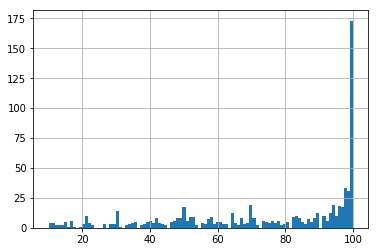

In [13]:
%matplotlib inline
df_amendements_matched["Simi"] = df_amendements_matched["Similarité"]\
.apply(lambda x:int(x.replace("%", "")))
df_amendements_matched.Simi.hist(bins=100)

In [ ]:
del df_amendements_matched["Simi"]

In [21]:
df_amendements_1.head()

,nb_1,txt,begin,end
0,CE166,"« et durable » les mots : « , durable et respe...",1,21
1,CE170,Larticle L. 230-5 du code rural et de la pêc...,21,44
2,CE466,Larticle L. 230-5 du code rural et de la pêc...,44,68
3,CE520,"AVANT L'ARTICLE 11, insérer l'article suivant...",68,94
4,CE168,« Accès à une alimentation saine »,94,114


In [32]:
df_results = pd.merge(df_amendements_2, df_amendements_matched, left_on = "nb_2", right_on="N° v2", \
                      how='left')

df_results["N° v2"] = df_results["nb_2"]
df_results["Amendement v2"] = df_results["txt"]

del df_results["begin"], df_results["end"], df_results["nb_2"], df_results["txt"]

df_results["N° v1"].fillna("non trouvé", inplace = True)
df_results["Amendement v1"].fillna("non trouvé", inplace = True)
df_results["Similarité"].fillna("0%", inplace = True)

len(df_results)
df_results.head()

,N° v1,N° v2,Amendement v1,Amendement v2,Similarité
0,CE36,249,Après le II de larticle L. 211-1 du code de ...,Après le II de larticle L. 211-1 du code de ...,100%
1,CE381,450,Le III de larticle L. 341-1 du code rural et ...,Le 9° du II de larticle L. 110-1 du code de l...,11%
2,non trouvé,444,non trouvé,Au IV de larticle L. 122-1 du code de lenvir...,0%
3,non trouvé,453,non trouvé,Après le V de larticle L. 122-1 du code de l...,0%
4,non trouvé,451,non trouvé,Les articles L. 181-7 et L. 514-6 du code de l...,0%


In [9]:
df_amendements_matched.to_excel('correspondance_amendements.xlsx', index=False)

# Matching with previous excel

In [32]:
excel1 = pd.read_excel('ancien_derouleur.xlsx')
excel2 = pd.read_excel('nouveau_derouleur_a_remplir2.xlsx')

In [13]:
def get_avis(df, nb):
    avis = df[df["N°"]==nb]["Avis SAJ "].values[0]
    return avis

def get_corresp_avis(corresp, nb):
    if nb in corresp:
        return get_avis(excel1, corresp[nb][0])
    return ""

def get_old_new_txt(corresp, nb):
    if nb in corresp:
        return (corresp[nb][1], corresp[nb][2], corresp[nb][3])
    return ("","","")

def get_text(df, nb):
    df_t = df[df.nb_2==nb]
    if len(df_t)>0:
        return df_t.txt.values[0]
    return ""

In [14]:
avis, old_txt, new_txt, difference_txt, txt2= [], [], [], [], []
for i2, row2 in excel2.iterrows():
    nb2 = str(row2["N°"])
    avis.append(get_corresp_avis(corresp, nb2))
    extra_cols = get_old_new_txt(corresp, nb2)
    old_txt.append(extra_cols[0])
    new_txt.append(extra_cols[1])
    txt2.append(get_text(df_amendements_2, nb2))
    difference_txt.append(extra_cols[2])

In [33]:
excel2["Avis SAJ"]=avis
excel2["Amendent v1"]=old_txt
excel2["Amendent v2"]=txt2
excel2["Similarité"]=difference_txt

In [37]:
excel2["N°"] = excel2["N°"].apply(lambda x:str(x))
df_tmp = pd.DataFrame(excel2.groupby("txt_amendement")["N°"].agg(['count', "min"])).reset_index()


def has_similar(df_tmp, txt):
    if len(txt)<3:
        return ""
    if df_tmp[df_tmp["txt_amendement"]==txt]["count"].values[0] > 1:
        return 'Amendement similaire au ' + str( df_tmp[df_tmp["txt_amendement"]==txt]["min"].values[0])
    return ""

In [38]:
similars = []
for i2, row2 in excel2.iterrows():
    similars.append(has_similar(df_tmp, row2.txt_amendement))

In [39]:
excel2["Amendent similaire ?"]=similars

In [40]:
excel2.to_excel('nouveau_derouleur_post_traitement.xlsx')